# ArXiv Semantic Graph – Project Demo

This notebook demonstrates the main steps of our pipeline:

1. Exploratory Data Analysis (EDA)
2. Embeddings (Universal Sentence Encoder)
3. HNSW index for fast nearest neighbours
4. Distance histogram and global threshold τ
5. Semantic graph construction
6. Graph clustering (Louvain communities)
7. Semantic recommendation demo


## Section 0 - Imports and paths

In [8]:
# ============================
# SECTION 0 — PROJECT SETUP
# ============================

from pathlib import Path
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# -----------------------------
# 0.1 — Resolve project paths
# -----------------------------
# Your repo structure:
# project/
#   ├─ src/
#   ├─ outputs/
#   ├─ notebooks/
#   └─ data/

NOTEBOOK_DIR = Path.cwd()
ROOT = NOTEBOOK_DIR.parent
SRC = ROOT / "src"

print("ROOT:", ROOT)
print("SRC:", SRC)

# -----------------------------
# 0.2 — Add src/ to PYTHONPATH
# -----------------------------
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

print("\nPYTHONPATH updated. Current sys.path first entries:")
print("\n".join(sys.path[:3]))

# -----------------------------
# 0.3 — Project imports
# -----------------------------
from arxiv_semantic_graph import eda, embeddings, graph, graph_clustering, recommend

print("\n[OK] Project modules imported successfully.")

# -----------------------------
# 0.4 — Paths to data and outputs
# -----------------------------
DATA_PATH = ROOT / "data" / "arxiv-metadata-oai-snapshot.json"

OUTPUTS = ROOT / "outputs"
OUTPUTS.mkdir(exist_ok=True)

EMB_DIR = OUTPUTS / "embeddings"
if not EMB_DIR.exists():
    print(
        f"Embeddings directory not found at:\n{EMB_DIR}\n"
        "Run the embedding extraction pipeline first."
    )

# -----------------------------
# 0.5 — Locate embedding shards
# -----------------------------
emb_paths = sorted(EMB_DIR.glob("emb_*.npy"))
if not emb_paths:
    print(f"No embedding shards found in {EMB_DIR}")

print(f"\n[Info] Found {len(emb_paths)} embedding shards.")


ROOT: /home/zealot/DTU/Computational_Tools
SRC: /home/zealot/DTU/Computational_Tools/src

PYTHONPATH updated. Current sys.path first entries:
/home/zealot/DTU/Computational_Tools/src
/home/zealot/micromamba/envs/arxivrec/lib/python311.zip
/home/zealot/micromamba/envs/arxivrec/lib/python3.11

[OK] Project modules imported successfully.
Embeddings directory not found at:
/home/zealot/DTU/Computational_Tools/outputs/embeddings
Run the embedding extraction pipeline first.
No embedding shards found in /home/zealot/DTU/Computational_Tools/outputs/embeddings

[Info] Found 0 embedding shards.


## Section 1 - EDA

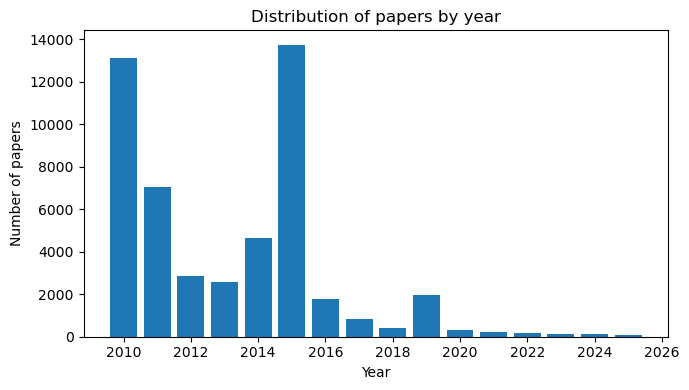

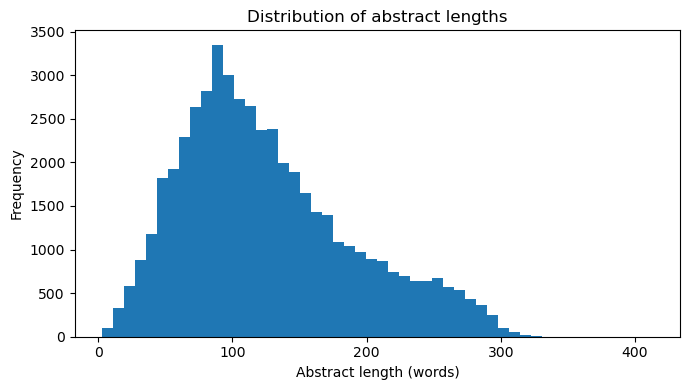

In [9]:
years, lengths = eda.load_eda_data(
    file_path=str(DATA_PATH),
    max_papers=50000,
    min_year=2010,
)

stats = eda.compute_eda_stats(years, lengths)

eda.plot_year_distribution(years, save_path=None, show=True)
eda.plot_length_distribution(lengths, save_path=None, show=True)

## Section 2 -Embeddings

In [10]:
import sys, tensorflow as tf
print(sys.executable)
print(tf.__version__)
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices("GPU"))


/home/zealot/micromamba/envs/arxivrec/bin/python
2.15.0
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
DATA_PATH = Path("../data/arxiv-metadata-oai-snapshot.json")
EMB_DIR = Path("../outputs/embeddings")
EMB_DIR.mkdir(exist_ok=True)

total_embedded = embeddings.run_embeddings(
    file_path=str(DATA_PATH),
    out_dir=str(EMB_DIR),
    batch_size=64,
    shard_size=25000,
    min_year=2020,
    min_words=75,
    use_gpu=True,           # ← ENABLE GPU
    vram_mib=4096,          # ← OPTIONAL: cap GPU memory
    force_recompute=False,
)

print("Total embedded:", total_embedded)


[GPU] Using logical GPU capped at ~4096 MiB
[Embeddings] Reading from: ../data/arxiv-metadata-oai-snapshot.json
[Embeddings] Writing shards to: ../outputs/embeddings
[Embeddings] Filters: min_year=2020, min_words=75
[Embeddings] Batch size: 64, Shard size: 25000
[USE] Loading Universal Sentence Encoder...
[USE] Model loaded successfully
[Embeddings] Starting streaming and embedding...
[Shard 0] saved 25000 papers (total 25000)
[Shard 1] saved 25000 papers (total 50000)
[Shard 2] saved 25000 papers (total 75000)
[Shard 3] saved 25000 papers (total 100000)
[Shard 4] saved 25000 papers (total 125000)
[Shard 5] saved 25000 papers (total 150000)
[Shard 6] saved 25000 papers (total 175000)
[Shard 7] saved 25000 papers (total 200000)
[Shard 8] saved 25000 papers (total 225000)
[Shard 9] saved 25000 papers (total 250000)
[Shard 10] saved 25000 papers (total 275000)
[Shard 11] saved 25000 papers (total 300000)
[Shard 12] saved 25000 papers (total 325000)
[Shard 13] saved 25000 papers (total 350

## Section 3 - HNSW

In [12]:
import glob
from arxiv_semantic_graph.graph import load_shapes, build_or_load_index


# 3.1 – Locate embedding shards
emb_paths = sorted(glob.glob(str(EMB_DIR / "emb_*.npy")))
assert emb_paths, f"No emb_*.npy files found in {EMB_DIR}"

N, D = load_shapes(emb_paths)
print(f"[Info] Total vectors: {N:,} | Dimension: {D}")

# 3.2 – Build or load HNSW index
index = build_or_load_index(
    emb_paths=emb_paths,
    dim=D,
    out_dir=OUTPUTS / "hnsw",
    efc=200,   # ef_construction (controls construction quality vs speed)
    M=16,      # maximum number of connections per node
    threads=8,
)

# 3.3 – Quick sanity check: k-NN query for a random paper
import random
import numpy as np

random_id = random.randint(0, N - 1)

# Load the actual embedding for that paper (better than using a dummy vector)
offset = 0
query_vec = None
for p in emb_paths:
    arr = np.load(p, mmap_mode="r")
    n = arr.shape[0]
    if random_id < offset + n:
        query_vec = arr[random_id - offset].astype("float32")
        break
    offset += n

assert query_vec is not None, "Could not locate embedding for random_id"

labels, dists = index.knn_query(query_vec.reshape(1, -1), k=5)

print(f"[HNSW] Index is ready.")
print(f"[HNSW] Example query for id {random_id} returns {labels.shape[1]} neighbors.")
print("Neighbor IDs:", labels[0])
print("Distances:   ", dists[0])


[Info] Total vectors: 1,226,108 | Dimension: 512
[HNSW] Building index…
  Added 25000/1226108
  Added 50000/1226108
  Added 75000/1226108
  Added 100000/1226108
  Added 125000/1226108
  Added 150000/1226108
  Added 175000/1226108
  Added 200000/1226108
  Added 225000/1226108
  Added 250000/1226108
  Added 275000/1226108
  Added 300000/1226108
  Added 325000/1226108
  Added 350000/1226108
  Added 375000/1226108
  Added 400000/1226108
  Added 425000/1226108
  Added 450000/1226108
  Added 475000/1226108
  Added 500000/1226108
  Added 525000/1226108
  Added 550000/1226108
  Added 575000/1226108
  Added 600000/1226108
  Added 625000/1226108
  Added 650000/1226108
  Added 675000/1226108
  Added 700000/1226108
  Added 725000/1226108
  Added 750000/1226108
  Added 775000/1226108
  Added 800000/1226108
  Added 825000/1226108
  Added 850000/1226108
  Added 875000/1226108
  Added 900000/1226108
  Added 925000/1226108
  Added 950000/1226108
  Added 975000/1226108
  Added 1000000/1226108
  Added 10

## Section 4 — Distance histogram & τ

In [13]:
# ---------------------------
# Section 3 — HNSW Index
# ---------------------------

from pathlib import Path
import glob
import numpy as np
from arxiv_semantic_graph.graph import load_shapes, build_or_load_index

print("[Section 3] Building or loading HNSW index...")

# 3.1 Locate embedding shards
EMB_DIR = ROOT / "outputs" / "embeddings"
emb_paths = sorted(glob.glob(str(EMB_DIR / "emb_*.npy")))
assert emb_paths, f"No embedding shards found in: {EMB_DIR}"

# 3.2 Get total vectors (N) and dimensionality (D)
N, D = load_shapes(emb_paths)
print(f"[Info] Total vectors = {N:,} | Dimension = {D}")

# 3.3 Build or load HNSW index
index = build_or_load_index(
    emb_paths=emb_paths,
    dim=D,
    out_dir=OUTPUTS / "hnsw",
    efc=200,
    M=16,
    threads=8,
)

print("[Section 3] HNSW index ready.")
print()


[Section 3] Building or loading HNSW index...
[Info] Total vectors = 1,226,108 | Dimension = 512
[HNSW] Building index…
  Added 25000/1226108
  Added 50000/1226108
  Added 75000/1226108
  Added 100000/1226108
  Added 125000/1226108
  Added 150000/1226108
  Added 175000/1226108
  Added 200000/1226108
  Added 225000/1226108
  Added 250000/1226108
  Added 275000/1226108
  Added 300000/1226108
  Added 325000/1226108
  Added 350000/1226108
  Added 375000/1226108
  Added 400000/1226108
  Added 425000/1226108
  Added 450000/1226108
  Added 475000/1226108
  Added 500000/1226108
  Added 525000/1226108
  Added 550000/1226108
  Added 575000/1226108
  Added 600000/1226108
  Added 625000/1226108
  Added 650000/1226108
  Added 675000/1226108
  Added 700000/1226108
  Added 725000/1226108
  Added 750000/1226108
  Added 775000/1226108
  Added 800000/1226108
  Added 825000/1226108
  Added 850000/1226108
  Added 875000/1226108
  Added 900000/1226108
  Added 925000/1226108
  Added 950000/1226108
  Added 9

In [14]:
from arxiv_semantic_graph.graph import (
    compute_knn_distance_histogram,
    choose_tau_from_percentile,
)

print("[Section 4] Computing k-NN distance histogram...")

hist_result = compute_knn_distance_histogram(
    emb_dir=str(EMB_DIR),
    index=index,
    k=6,                      # 1 (self) + 5 neighbors
    out_dir=str(OUTPUTS / "eda")   # Stores plots & stats
)

hist_summary = hist_result["summary"]
hist_summary


[Section 4] Computing k-NN distance histogram...
[Histogram] Computing distance distributions with k=6…
  Processed 100000 vectors
  Processed 200000 vectors
  Processed 300000 vectors
  Processed 400000 vectors
  Processed 500000 vectors
  Processed 600000 vectors
  Processed 700000 vectors
  Processed 800000 vectors
  Processed 900000 vectors
  Processed 1000000 vectors
  Processed 1100000 vectors
  Processed 1200000 vectors
[Histogram] Statistics: {
  "mean": 0.24670337863040692,
  "median": 0.24713581800460815,
  "std": 0.045540458174666974,
  "min": -5.960464477539062e-07,
  "max": 0.6815634369850159
}


{'mean': 0.24670337863040692,
 'median': 0.24713581800460815,
 'std': 0.045540458174666974,
 'min': -5.960464477539062e-07,
 'max': 0.6815634369850159}

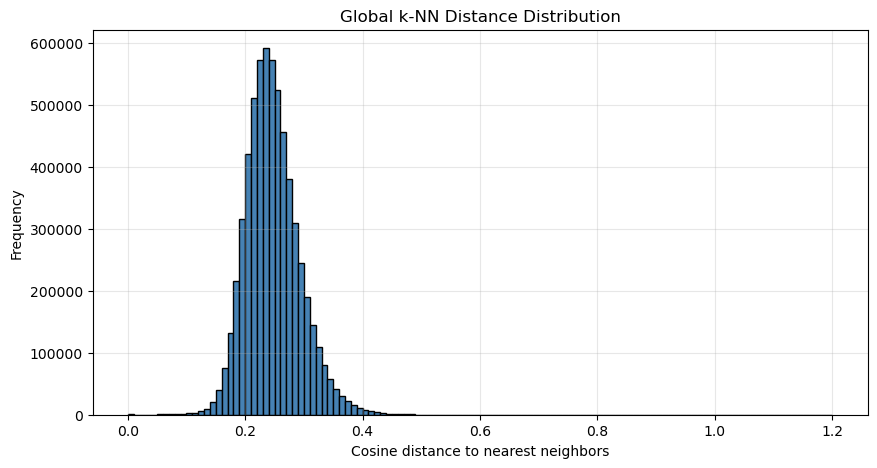

In [15]:
import matplotlib.pyplot as plt
import numpy as np

bins = hist_result["bins"]
global_hist = hist_result["global_hist"]
centers = 0.5 * (bins[1:] + bins[:-1])

plt.figure(figsize=(10, 5))
plt.bar(centers, global_hist, width=(bins[1] - bins[0]), color="steelblue", edgecolor="black")
plt.xlabel("Cosine distance to nearest neighbors")
plt.ylabel("Frequency")
plt.title("Global k-NN Distance Distribution")
plt.grid(alpha=0.3)
plt.show()


In [16]:
# Define candidate p_keep values
pkeep_candidates = [0.05, 0.10, 0.15, 0.20, 0.25]

tau_candidates = []

for p in pkeep_candidates:
    tau = choose_tau_from_percentile(
        hist_result["bins"],
        hist_result["global_hist"],
        pkeep=p
    )
    tau_candidates.append((p, tau))

tau_candidates


[Threshold] tau ≈ 0.1900 (≈5th percentile)
[Threshold] tau ≈ 0.2000 (≈10th percentile)
[Threshold] tau ≈ 0.2100 (≈15th percentile)
[Threshold] tau ≈ 0.2100 (≈20th percentile)
[Threshold] tau ≈ 0.2200 (≈25th percentile)


[(0.05, 0.19), (0.1, 0.2), (0.15, 0.21), (0.2, 0.21), (0.25, 0.22)]

In [17]:
import pandas as pd

tau_df = pd.DataFrame(
    [{"p_keep": p, "tau": tau} for p, tau in tau_candidates]
)

tau_file = OUTPUTS / "tau_candidates.csv"
tau_df.to_csv(tau_file, index=False)

print("Saved τ candidates to:", tau_file)

tau_df


Saved τ candidates to: /home/zealot/DTU/Computational_Tools/outputs/tau_candidates.csv


,p_keep,tau
0,0.05,0.19
1,0.10,0.20
2,0.15,0.21
3,0.20,0.21
4,0.25,0.22


## Section 5 — Graph construction

In [18]:
# Locate embedding shards (they must already exist)
emb_paths = sorted(glob.glob(str(EMB_DIR / "emb_*.npy")))
if not emb_paths:
    raise RuntimeError(
        f"No embedding shards found in {EMB_DIR}. "
        "Run the embedding extraction pipeline before this notebook."
    )

# Basic embedding stats
N, D = load_shapes(emb_paths)
print(f"[Setup] Found {len(emb_paths)} shards: {N:,} vectors, dim={D}")


[Setup] Found 50 shards: 1,226,108 vectors, dim=512


In [19]:
# ==============================================================
# Section 5 — Build and evaluate graphs for multiple τ thresholds
# ==============================================================

from pathlib import Path
import pandas as pd

from arxiv_semantic_graph.graph import (
    build_graph_for_tau,
    compute_graph_stats,
)

# ----------------------------------------------
# 5.0 – Load tau candidates from the saved CSV
# ----------------------------------------------

TAU_CSV = OUTPUTS / "tau_candidates.csv"

if not TAU_CSV.exists():
    raise FileNotFoundError(
        f"Tau candidate file not found at {TAU_CSV}. "
        "Run Section 4 first to compute histogram & tau values."
    )

tau_df = pd.read_csv(TAU_CSV)
display(tau_df)

# Convert DF into list of (pkeep, tau)
tau_candidates = list(zip(tau_df["p_keep"], tau_df["tau"]))
print("\n[Info] Loaded tau candidates:")
for p, t in tau_candidates:
    print(f"  pkeep={p:.2f} → tau={t:.4f}")

index = build_or_load_index(
    emb_paths=emb_paths,
    dim=D,
    out_dir=OUTPUTS / "hnsw",
    efc=200,   # ef_construction (controls construction quality vs speed)
    M=16,      # maximum number of connections per node
    threads=8,
)

# ----------------------------------------------
# 5.1 – Prepare output directory for graph files
# ----------------------------------------------

GRAPH_DIR = OUTPUTS / "graphs"
GRAPH_DIR.mkdir(exist_ok=True)

graph_summaries = []

print("\n[Graph] Starting graph construction for each tau...\n")

# -----------------------------------------------------
# 5.2 – Build graphs for each τ + compute their metrics
# -----------------------------------------------------

seen_taus = set()
graph_summaries = []

for pkeep, tau in tau_candidates:
    tau_rounded = round(tau, 3)
    if tau_rounded in seen_taus:
        print(f"[Graph] Skipping pkeep={pkeep:.2f}: tau={tau_rounded} already used.")
        continue
    seen_taus.add(tau_rounded)

    tau_tag = f"tau_{tau_rounded:.3f}".replace(".", "p")
    out_dir = GRAPH_DIR / tau_tag
    out_dir.mkdir(parents=True, exist_ok=True)

    print("=" * 80)
    print(f"[Graph] Building graph for pkeep={pkeep:.2f}, tau≈{tau_rounded:.4f}")

    edge_path = build_graph_for_tau(
        emb_dir=str(EMB_DIR),
        index=index,
        tau=tau,
        k_for_search=50,          # Number of neighbors to retrieve
        out_dir=str(out_dir),
        sample_edges=1000,        # For inspection only
    )

    # Compute metrics
    stats = compute_graph_stats(edge_path=edge_path, num_nodes=N)

    graph_summaries.append({
        "pkeep": pkeep,
        "tau": tau,
        "nodes": stats["nodes"],
        "edges": stats["edges"],
        "avg_degree": stats["avg_degree"],
        "median_degree": stats["median_degree"],
        "isolated_nodes": stats["isolated_nodes"],
    })

# ----------------------------------------------
# 5.3 – Save results into a summary CSV
# ----------------------------------------------

graphs_df = pd.DataFrame(graph_summaries)
graphs_df_path = GRAPH_DIR / "graph_summaries.csv"
graphs_df.to_csv(graphs_df_path, index=False)

print("\n[Graph] Summary of constructed graphs:")
display(graphs_df)
print(f"[Graph] Saved summary to: {graphs_df_path}")


,p_keep,tau
0,0.05,0.19
1,0.10,0.20
2,0.15,0.21
3,0.20,0.21
4,0.25,0.22



[Info] Loaded tau candidates:
  pkeep=0.05 → tau=0.1900
  pkeep=0.10 → tau=0.2000
  pkeep=0.15 → tau=0.2100
  pkeep=0.20 → tau=0.2100
  pkeep=0.25 → tau=0.2200
[HNSW] Building index…
  Added 25000/1226108
  Added 50000/1226108
  Added 75000/1226108
  Added 100000/1226108
  Added 125000/1226108
  Added 150000/1226108
  Added 175000/1226108
  Added 200000/1226108
  Added 225000/1226108
  Added 250000/1226108
  Added 275000/1226108
  Added 300000/1226108
  Added 325000/1226108
  Added 350000/1226108
  Added 375000/1226108
  Added 400000/1226108
  Added 425000/1226108
  Added 450000/1226108
  Added 475000/1226108
  Added 500000/1226108
  Added 525000/1226108
  Added 550000/1226108
  Added 575000/1226108
  Added 600000/1226108
  Added 625000/1226108
  Added 650000/1226108
  Added 675000/1226108
  Added 700000/1226108
  Added 725000/1226108
  Added 750000/1226108
  Added 775000/1226108
  Added 800000/1226108
  Added 825000/1226108
  Added 850000/1226108
  Added 875000/1226108
  Added 900000

,pkeep,tau,nodes,edges,avg_degree,median_degree,isolated_nodes
0,0.05,0.19,1226108,498570,0.813256,2.0,1010994
1,0.10,0.20,1226108,974196,1.589087,2.0,918935
2,0.15,0.21,1226108,1768828,2.885273,3.0,811759
3,0.25,0.22,1226108,2972244,4.848258,3.0,696141


[Graph] Saved summary to: /home/zealot/DTU/Computational_Tools/outputs/graphs/graph_summaries.csv


In [ ]:
from arxiv_semantic_graph.graph import build_graph_for_tau, compute_graph_stats

GRAPH_DIR = OUTPUTS / "graphs"
GRAPH_DIR.mkdir(exist_ok=True)

graph_summaries = []

for pkeep, tau in tau_candidates:
    tau_tag = f"tau_{tau:.3f}".replace(".", "p")
    out_dir = GRAPH_DIR / tau_tag
    out_dir.mkdir(parents=True, exist_ok=True)

    print("=" * 80)
    print(f"[Graph] Building graph for pkeep={pkeep:.2f} (tau={tau:.4f})")

    edge_path = build_graph_for_tau(
        emb_dir=str(EMB_DIR),
        index=index,
        tau=tau,
        k_for_search=50,
        out_dir=str(out_dir),
        sample_edges=500,
    )

    stats = compute_graph_stats(edge_path=edge_path, num_nodes=N)

    graph_summaries.append({
        "pkeep": pkeep,
        "tau": tau,
        "nodes": stats["nodes"],
        "edges": stats["edges"],
        "avg_degree": stats["avg_degree"],
        "median_degree": stats["median_degree"],
        "isolated_nodes": stats["isolated_nodes"],
    })

graphs_df = pd.DataFrame(graph_summaries)
graphs_df.to_csv(GRAPH_DIR / "graph_summaries.csv", index=False)

display(graphs_df)


[Graph] Building graph for pkeep=0.05 (tau=0.1900)
[Graph] Building edge list at tau=0.1900, k=50
  Processed nodes 0-20000
  Processed nodes 20000-25000
  Processed nodes 25000-45000
  Processed nodes 45000-50000
  Processed nodes 50000-70000
  Processed nodes 70000-75000
  Processed nodes 75000-95000
  Processed nodes 95000-100000
  Processed nodes 100000-120000


## Section 6 - Louvain communities

In [ ]:
tau_star = tau_candidates[1]
edge_path_star = [r["edge_path"] for r in results_tau if r["tau"] == tau_star][0]

CLUSTER_OUT = OUTPUTS / "clustering"
CLUSTER_OUT.mkdir(exist_ok=True)

louvain_result = graph_clustering.run_louvain(
    edge_path=edge_path_star,
    num_nodes=N,
    out_dir=str(CLUSTER_OUT),
)

## Section 7 - Recomendation demo

In [ ]:
meta = recommend.load_metadata(str(EMB_DIR))

recs = recommend.recommend_random(
    index=index,
    emb_dir=str(EMB_DIR),
    metadata=meta,
    k=5,
    tau=tau_star,
    louvain_labels=louvain_result["labels"],
)